<a href="https://colab.research.google.com/github/js22ado/applied-data-science/blob/main/Finalcodedesertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [3]:
set_random_seed(66)

In [4]:
# Fetch data for a our stock, JP MORGAN, from Yahoo Finance
ticker = 'JPM'
data = yf.download(ticker, start="2018-01-01", end="2023-01-01")

[*********************100%%**********************]  1 of 1 completed


# **DATA** **PREPROCESSING**

In [5]:
# Taking a quick look at our Dataset
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,107.629997,108.019997,106.809998,107.949997,89.602837,13578800
2018-01-03,107.860001,108.489998,107.480003,108.059998,89.694160,11901000
2018-01-04,108.360001,110.029999,108.199997,109.040001,90.979080,12953700
2018-01-05,109.260002,109.550003,107.779999,108.339996,90.395012,14155000
2018-01-08,108.150002,108.680000,107.699997,108.500000,90.528511,12466500


In [6]:
# View the data types and non-null values in the dataset
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
# Doing some descriptive stats to understand the central tendancies
# and variabilities of the Data
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,122.973932,124.233241,121.699055,122.948689,110.338246,1.455560e+07
std,21.388094,21.422361,21.337189,21.379160,22.144002,6.674322e+06
min,81.559998,83.750000,76.910004,79.029999,69.640205,3.220500e+06
25%,108.000000,108.814999,106.605000,107.864998,92.085014,1.020565e+07
50%,115.639999,116.680000,114.669998,115.550003,103.063644,1.290460e+07
75%,137.260002,138.195000,136.184998,137.245003,126.303814,1.657100e+07
max,172.710007,172.960007,170.539993,171.779999,159.780823,5.441880e+07


In [8]:
# Check for missing values
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
# Cheking for duplicate values
duplicates = data.duplicated()

if duplicates.any():
    print("The DataFrame has duplicates.")
else:
    print("The DataFrame does not have duplicates.")

The DataFrame does not have duplicates.


In [10]:
# Outlier detection
close_prices = data['Close']
# Calculate daily returns
daily_returns = close_prices.pct_change()
# Calculating z-scores for each data point
z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()
# Set a threshold for identifying outliers
threshold = 3
# Identify outliers
outliers = z_scores[abs(z_scores) > threshold]
"""# Remove outliers from the 'data' DataFrame
data = data[data.index.isin(outliers.index) == False]"""
print(data)




                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  107.629997  108.019997  106.809998  107.949997   89.602837   
2018-01-03  107.860001  108.489998  107.480003  108.059998   89.694160   
2018-01-04  108.360001  110.029999  108.199997  109.040001   90.979080   
2018-01-05  109.260002  109.550003  107.779999  108.339996   90.395012   
2018-01-08  108.150002  108.680000  107.699997  108.500000   90.528511   
...                ...         ...         ...         ...         ...   
2022-12-23  130.580002  131.440002  129.639999  131.279999  125.963997   
2022-12-27  131.570007  132.220001  130.550003  131.740005  126.405396   
2022-12-28  131.850006  133.410004  131.009995  132.460007  127.096237   
2022-12-29  132.929993  133.270004  132.309998  133.220001  127.825432   
2022-12-30  132.809998  134.330002  132.440002  134.100006  128.669815   

              Volume  
Date          

# **EXPLORATORY** **DATA** **ANALYSIS**

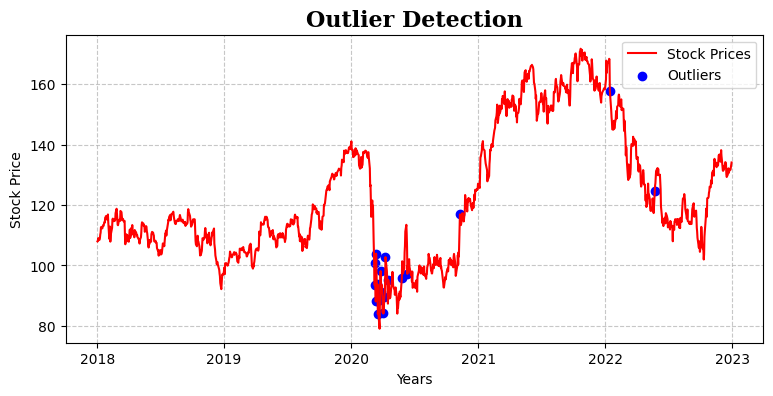

Number of outliers: 19


In [53]:
# Plot the stock prices with identified outliers
plt.figure(figsize=(9, 4))
plt.plot(close_prices.index, close_prices.values,
         label='Stock Prices', color='r')
plt.scatter(outliers.index, close_prices[outliers.index],
            color='b', label='Outliers')
plt.title('Outlier Detection', fontsize=16,
          fontweight='bold', fontfamily='serif')
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Number of outliers: {len(outliers)}")

In [12]:
# Extract the 'open' prices from the DataFrame
df2 = data.reset_index()['Open']
df2

0       107.629997
1       107.860001
2       108.360001
3       109.260002
4       108.150002
           ...    
1254    130.580002
1255    131.570007
1256    131.850006
1257    132.929993
1258    132.809998
Name: Open, Length: 1259, dtype: float64

**OPENING** **PRICE** **PLOT**

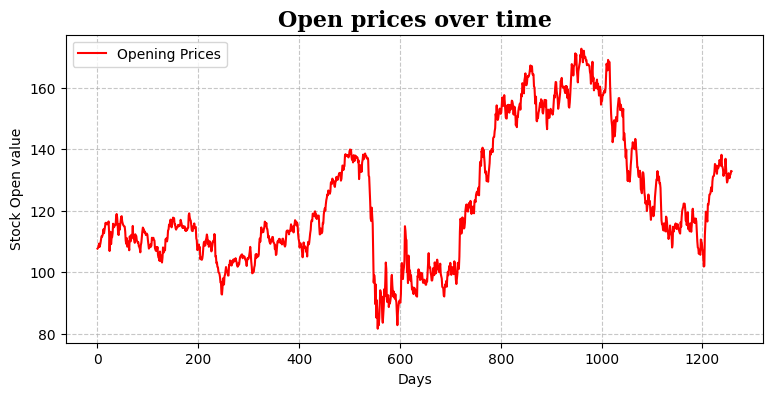

In [13]:
def plot_opening_prices(data):
    """
    Plots the opening prices to inspect for trends.

    Parameters:
    - data: Pandas Series containing opening prices

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, c='r')
    plt.xlabel('Days')
    plt.ylabel('Stock Open value')
    plt.title("Open prices over time", fontsize=16,
              fontweight='bold', fontfamily='serif')
    plt.legend(['Opening Prices', 'Data Points'], loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

#function call
plot_opening_prices(df2)

**CLOSING** **PRICE** **PLOT**

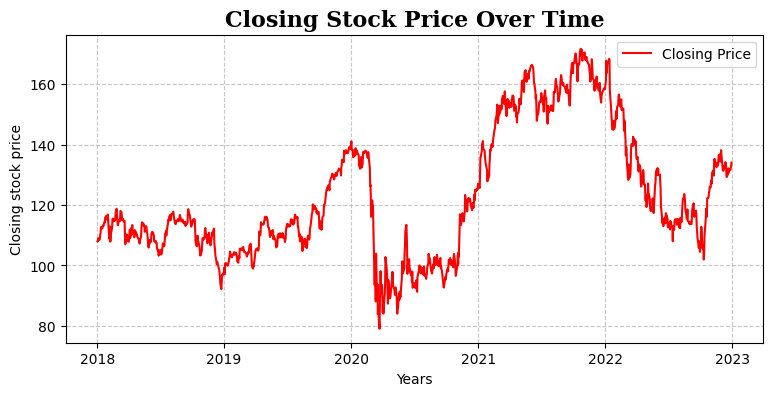

In [52]:
def plot_closing_prices(data):
    """
    Plots the closing stock price over time.

    Parameters:
    - data: Pandas DataFrame containing the 'Date' and 'Close' columns

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    sns.lineplot(x='Date', y='Close', data=data, color='r',
                 label='Closing Price')
    plt.title('Closing Stock Price Over Time', fontsize=16,
              fontweight='bold', fontfamily='serif')
    plt.xlabel('Years')
    plt.ylabel('Closing stock price')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

#function call
plot_closing_prices(data)

**VOLATILITY** **PLOT**

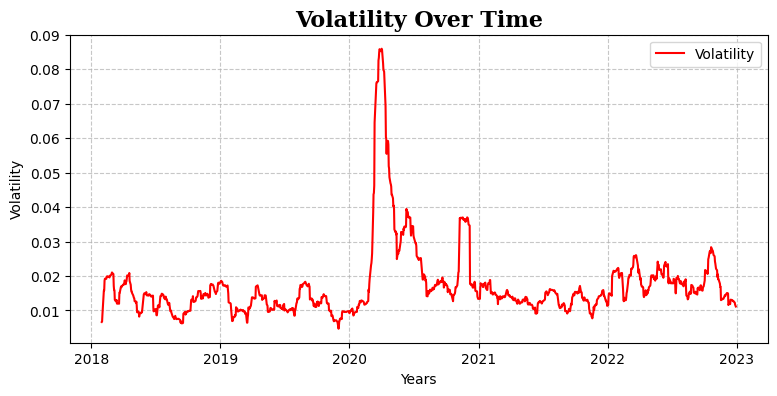

In [51]:
def plot_volatility(data, window_size=20):
    """
    Plots the volatility over time.

    Parameters:
    - data: Pandas Series containing the closing prices
    - window_size: Size of the rolling window for calculating volatility

    Returns:
    - None
    """
    daily_returns = data.pct_change()
    volatility = daily_returns.rolling(window=window_size).std()

    plt.figure(figsize=(9, 4))
    plt.plot(volatility.index, volatility.values, color='red',
             label='Volatility')
    plt.title('Volatility Over Time', fontsize=16,
              fontweight='bold', fontfamily='serif')
    plt.xlabel('Years')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

#function call
plot_volatility(close_prices, window_size=20)

**STOCK** **PERFORMANCE** **AND** **VOLUME** **OVER** **TIME**

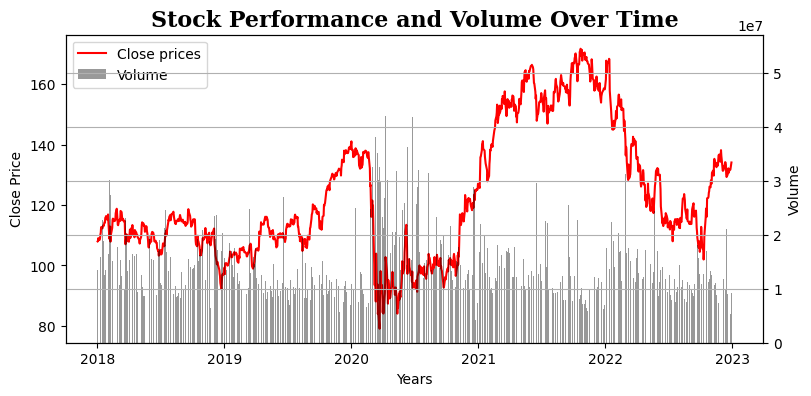

In [50]:
def plot_stock_volume(data):
    """
    Plots the stock performance and volume over time.

    Parameters:
    - data: Pandas DataFrame containing both 'Close' prices and volume data

    Returns:
    - None
    """
    fig, ax1 = plt.subplots(figsize=(9, 4))

    # Plotting the 'Close' prices on the first y-axis
    ax1.plot(data.index, data['Close'], label='Close prices', color='red')
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Close Price', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Creating the second y-axis for volume data
    ax2 = ax1.twinx()
    ax2.bar(data.index, data['Volume'], label='Volume', color='k', alpha=0.4)
    ax2.set_ylabel('Volume', color='k')
    ax2.tick_params(axis='y', labelcolor='k')

    # Title and legend
    plt.title('Stock Performance and Volume Over Time', fontsize=16,
              fontweight='bold', fontfamily='serif')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='upper left')
    plt.grid()
    plt.show()

#function call
plot_stock_volume(data)

**MIN** **MAX** **SCALING**

In [17]:
# Scale the data to a range between 0 and 1 as LSTMs are sensitive to scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

**TIME** **SERIES** **GENERATOR**

In [18]:
# Create the time series data structure
look_back = 50
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

**NUMPY** **ARRAY** **CREATION**

In [19]:
def create_dataset(dataset, time_step = 1):
  """
  Create sequences of 'time_step' consecutive values from the input time
  series 'dataset'.
  Parameters:
  - dataset (numpy.ndarray): Input time series data.
  - time_step (int): Number of consecutive time steps in each sequence.
  Returns:
  - numpy.ndarray, numpy.ndarray: Tuple containing dataX and dataY.
  """
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

**SPLITTING** **DATA**

In [20]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [21]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(956, 50)
(251, 50)


# **LONG** **SHORT**-**TERM** **MEMORY**(**LSTM**)

In [22]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

In [23]:
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=50, batch_size=32,
               validation_data=(X_test, Y_test))

Epoch 1/50
48/48 [==============================] - 26s 415ms/step - loss: 0.0441 - val_loss: 0.0057
Epoch 2/50
48/48 [==============================] - 8s 170ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 3/50
48/48 [==============================] - 8s 157ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch 4/50
48/48 [==============================] - 7s 140ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 5/50
48/48 [==============================] - 8s 170ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 6/50
48/48 [==============================] - 9s 198ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 7/50
48/48 [==============================] - 7s 139ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 8/50
48/48 [==============================] - 8s 169ms/step - loss: 0.0043 - val_loss: 0.0089
Epoch 9/50
48/48 [==============================] - 7s 141ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 10/50
48/48 [==============================] - 8s 168ms/step - loss: 0.0026 - val_loss: 0.003

In [24]:
# Build the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, return_sequences=True,
                        input_shape=(X_train.shape[1],1)))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1))

In [25]:
# Compile and fit RNN model
rnn_model.compile(loss = 'mean_squared_error', optimizer='adam')
rnn_model.fit(train_generator, epochs=50, batch_size=32)

Epoch 1/50
48/48 [==============================] - 5s 35ms/step - loss: 0.1615
Epoch 2/50
48/48 [==============================] - 2s 34ms/step - loss: 0.0198
Epoch 3/50
48/48 [==============================] - 2s 35ms/step - loss: 0.0068
Epoch 4/50
48/48 [==============================] - 2s 35ms/step - loss: 0.0034
Epoch 5/50
48/48 [==============================] - 2s 35ms/step - loss: 0.0022
Epoch 6/50
48/48 [==============================] - 2s 45ms/step - loss: 0.0048
Epoch 7/50
48/48 [==============================] - 2s 46ms/step - loss: 0.0018
Epoch 8/50
48/48 [==============================] - 2s 34ms/step - loss: 0.0026
Epoch 9/50
48/48 [==============================] - 2s 34ms/step - loss: 0.0028
Epoch 10/50
48/48 [==============================] - 2s 34ms/step - loss: 0.0035
Epoch 11/50
48/48 [==============================] - 2s 35ms/step - loss: 0.0030
Epoch 12/50
48/48 [==============================] - 2s 34ms/step - loss: 0.0032
Epoch 13/50
48/48 [==================

# **ARIMA**

**CHECKING** **DATA**

In [27]:
def test_stationarity(data):
    """
    Performs the Augmented Dickey-Fuller test to determine stationarity.

    Parameters:
    - data: Pandas Series containing the time series data

    Returns:
    - tuple: (adf_statistic, p_value, is_stationary, crit_values)
    """
    result = adfuller(data.dropna())
    adf_statistic, p_value, crit_values = result[0], result[1], result[4]

    # Determine if the series is stationary
    if p_value < 0.05:
        is_stationary = "Stationary"
    else:
        is_stationary = "Non-Stationary"

    for key, value in crit_values.items():
        print('Critial Values:')
        print(f'   {key}, {value}')

    return adf_statistic, p_value, is_stationary, crit_values

# Example function call
adf_statistic, p_value, is_stationary, crit_values = \
    test_stationarity(data['Close'])
print(f"ADF test statistics = {adf_statistic}")
print(f"p-value = {p_value}")
print(f"The series is {is_stationary}")

Critial Values:
   1%, -3.4356133204636095
Critial Values:
   5%, -2.8638642784217305
Critial Values:
   10%, -2.5680074748794373
ADF test statistics = -1.72567003276354
p-value = 0.4179373850434388
The series is Non-Stationary


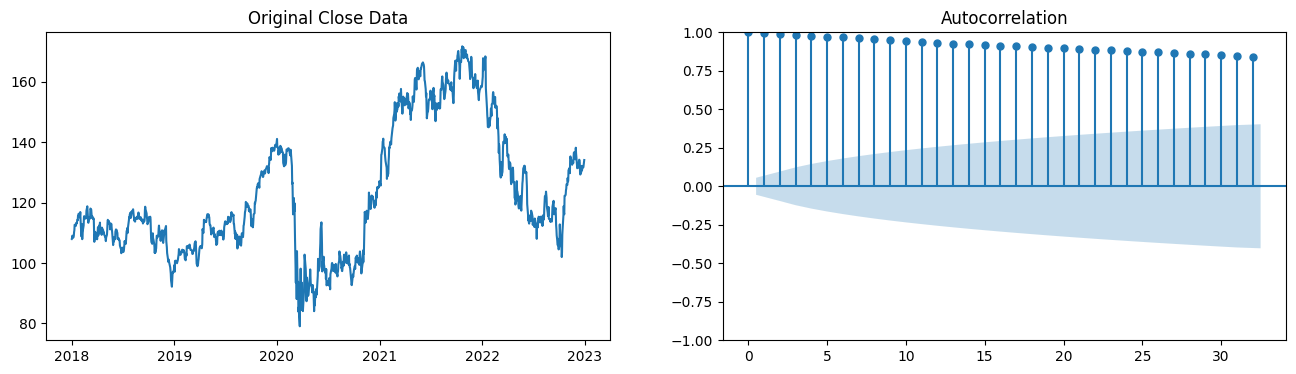

In [28]:
# plotting orginal data and acf

def plot_original_close_data_acf(data):
    """
    Plots the original close data and its autocorrelation function (ACF).

    Parameters:
    - data: Pandas Series containing the 'Close' prices

    Returns:
    - None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(data)
    ax1.set_title("Original Close Data")

    plot_acf(data, ax=ax2)
    plt.show()

# Example function call
plot_original_close_data_acf(data['Close'])

**FIRST** **DIFFERENCING**

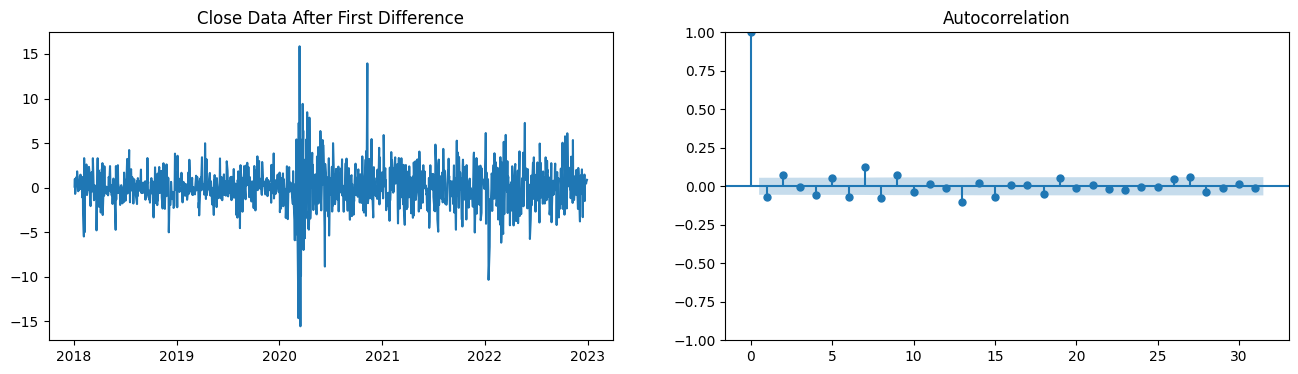

In [29]:
data_close=data['Close']
# calculating 1st difference
diff_data = data_close.diff().dropna()
#creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
#plotting
ax1.plot(diff_data)
ax1.set_title("Close Data After First Difference")

plot_acf(diff_data, ax=ax2)
plt.show()



In [31]:

#calling the same function with differenced data
adf_statistic, p_value, is_stationary, crit_values = \
    test_stationarity(diff_data)
print(f"ADF test statistics = {adf_statistic}")
print(f"p-value = {p_value}")
print(f"The series is {is_stationary}")


Critial Values:
   1%, -3.4356133204636095
Critial Values:
   5%, -2.8638642784217305
Critial Values:
   10%, -2.5680074748794373
ADF test statistics = -10.50185403063494
p-value = 1.0788871975752322e-18
The series is Stationary


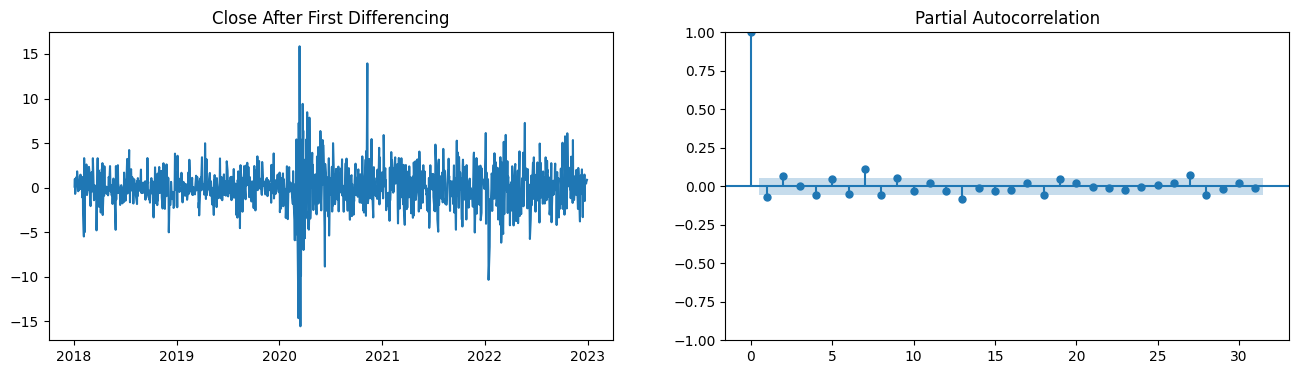

In [32]:
# close after 1st differencing and pacf plot
def plot_close_after_difference_pacf(data):
    """
    Plots the close data after the first differencing and its partial
     autocorrelation function (PACF).

    Parameters:
    - data: Pandas Series containing the time series data after differencing

    Returns:
    - None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(data)
    ax1.set_title("Close After First Differencing")

    ax2.set_ylim(0, 1)
    plot_pacf(data, ax=ax2)
    plt.show()

# Example function call
plot_close_after_difference_pacf(data['Close'].diff().dropna())

**AUTOARIMA**

In [33]:
# Using autoarima to find the best ARIMA model
autoarima_model = auto_arima(diff_data,stationary=True, seasonal=False,
                             start_p=0,start_q=0,max_p=8,max_q=8, d=1,
                             suppress_warnings=True)
best_order=autoarima_model.order
# Extracting the best order (p, d, q)
best_p, best_d, best_q = best_order
print(f"Best values for p, d, q: {best_p}, {best_d}, {best_q}")

print(autoarima_model.summary())

Best values for p, d, q: 3, 0, 2
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -2791.042
Date:                Thu, 02 May 2024   AIC                           5594.085
Time:                        08:56:11   BIC                           5624.909
Sample:                             0   HQIC                          5605.669
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5603      0.072    -21.730      0.000      -1.701      -1.420
ar.L2         -0.6561      0.087     -7.510      0.000      -0.827      -0.485
ar.L3          0.06

**MODEL** **FITTING**

In [34]:
# 3,0,2 ARIMA Model
model = ARIMA(data.Close, order=(3,0,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2795.309
Date:                Thu, 02 May 2024   AIC                           5604.618
Time:                        08:56:31   BIC                           5640.585
Sample:                             0   HQIC                          5618.134
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.9066     10.681     11.507      0.000     101.973     143.840
ar.L1         -0.6943      0.038    -18.385      0.000      -0.768      -0.620
ar.L2          0.8450      0.016     53.989      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**RESIDUAL** **ERRORS**

(array([0.00081451, 0.0002715 , 0.00108601, 0.01357518, 0.10045637,
        0.18489401, 0.03556698, 0.00434406, 0.0002715 , 0.00054301]),
 array([-15.29161636, -12.36612696,  -9.44063755,  -6.51514815,
         -3.58965874,  -0.66416934,   2.26132007,   5.18680947,
          8.11229888,  11.03778828,  13.96327769]),
 <BarContainer object of 10 artists>)

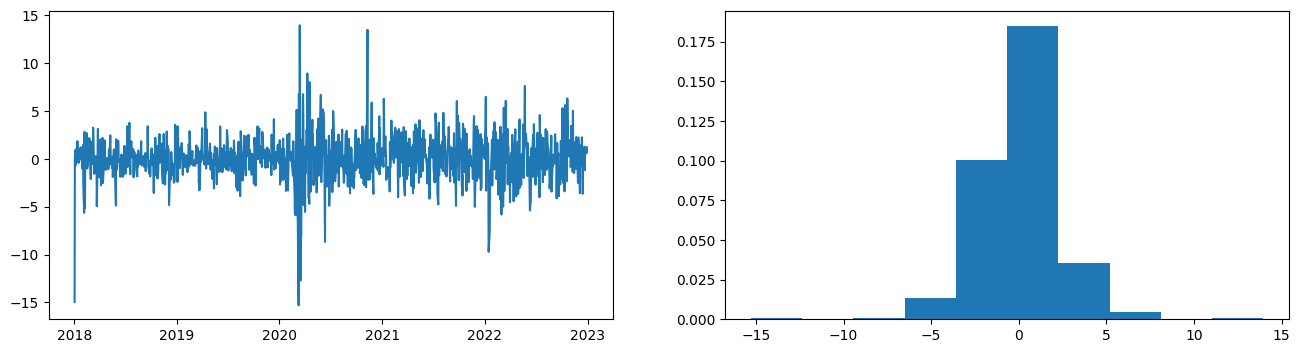

In [35]:
#plotting residual errors
""" not using on the code just finding the error"""

residuals = pd.DataFrame(model_fit.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)

ax2.hist(residuals, density=True)

**SPLITTING** **DATA**

In [36]:
def split_train_test_data(data, train_percentage):
    """
    Splits the data into training and testing sets.

    Parameters:
    - data: Pandas Series or DataFrame containing the data
    - train_percentage: Percentage of data to be used for training (0 to 1)

    Returns:
    - tuple: (train_data, test_data)
    """
    train_size = int(len(data) * train_percentage)
    train_data = pd.DataFrame(data[:train_size])
    test_data = pd.DataFrame(data[train_size:])

    return train_data, test_data

# Example function call
train, test = split_train_test_data(data['Close'], train_percentage=0.9)
print(train.shape)
print(test.shape)
testshape = test.shape

(1133, 1)
(126, 1)


In [37]:
model = ARIMA(train, order=(3, 0, 2))
res = model.fit()
#forecast shape
pred = res.forecast(steps=testshape[0])
conf = res.get_forecast(steps=testshape[0], alpha = 0.05)  # = 95% confidence
# #create confidence levels
confidence = conf.conf_int(alpha=0.05)

lower1 = pd.Series(confidence['lower Close'])
upper1 = pd.Series(confidence['upper Close'])

fc_series = pd.Series(data = pred.values, index=test.index)
lower_series = pd.Series(data = lower1.values, index=test.index,
                         name = 'lower Series')
upper_series = pd.Series(data = upper1.values, index=test.index, name=None)

print(lower_series)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
2022-07-05    109.358073
2022-07-06    108.055529
2022-07-07    106.742351
2022-07-08    105.582582
2022-07-11    104.921163
                 ...    
2022-12-23     80.950278
2022-12-27     80.886264
2022-12-28     80.823077
2022-12-29     80.760685
2022-12-30     80.699088
Name: lower Series, Length: 126, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stats

**FORECASTING** **ARIMA** **MODEL**

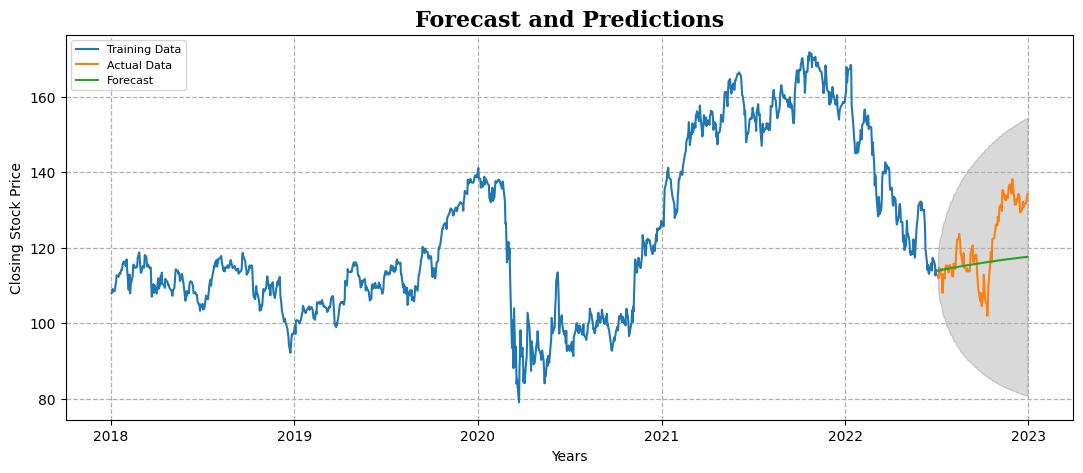

In [38]:
def plot_forecast(train_data, test_data, forecast_series, lower_confidence,
                  upper_confidence):
    """
    Plots the forecasted values along with training and testing data.

    Parameters:
    - train_data: Pandas Series or DataFrame containing the training data
    - test_data: Pandas Series or DataFrame containing the actual testing data
    - forecast_series: Pandas Series containing the forecasted values
    - lower_confidence: Pandas Series containing the lower confidence interval
     values
    - upper_confidence: Pandas Series containing the upper confidence interval
     values

    Returns:
    - None
    """
    plt.figure(figsize=(13, 5), dpi=100)

    plt.plot(train_data, label='Training Data')
    plt.plot(test_data, label='Actual Data')
    plt.plot(forecast_series, label='Forecast')

    plt.fill_between(lower_confidence.index, lower_confidence, upper_confidence,
                     color='k', alpha=0.15)

    plt.title('Forecast and Predictions', fontsize=16, fontweight='bold',
              fontfamily='serif')
    plt.xlabel('Years')
    plt.ylabel('Closing Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

# Example function call
plot_forecast(train, test, fc_series, lower_series, upper_series)

In [39]:
test.mean()

Close    120.738413
dtype: float64

**FINDING** **MSE**, **MAE** **AND** **RMSE** **OF** **ARIMA**

In [40]:

def calculate_errors(predicted, actual):
    """
    Calculates RMSE, MSE, and MAE.

    Parameters:
    - predicted: Pandas Series or NumPy array containing the predicted values
    - actual: Pandas Series or NumPy array containing the actual values

    Returns:
    - tuple: (rmse, mse, mae)
      - rmse: Root Mean Squared Error
      - mse: Mean Squared Error
      - mae: Mean Absolute Error
    """
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(actual, predicted))

    # Calculate MSE
    mse = mean_squared_error(actual, predicted)

    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)

    return rmse, mse, mae

# Example function call
rmse, mse, mae = calculate_errors(fc_series, test)
print('Mean Squared Error of ARIMA Model:', mse)
print('Mean Absolute Error of ARIMA Model:', mae)
print('Root Mean Squared Error of ARIMA Model', rmse)

Mean Squared Error of ARIMA Model: 101.12639777260463
Mean Absolute Error of ARIMA Model: 7.731102821196192
Root Mean Squared Error of ARIMA Model 10.0561621791121


In [41]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator)
lstm_predictions = lstm_model.predict(test_generator)


# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

actual_prices = scaler.inverse_transform(test_data[look_back:])

252/252 [==============================] - 8s 28ms/step


In [42]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

**MSE**,**MAE** **AND** **RMSE** **OF** **LSTM** **AND** **RNN** **MODELS**

In [44]:

def calculate_model_errors(actual_values, predictions):
    """
    Calculates MSE, MAE, and RMSE of the models.

    Parameters:
    - actual_values: NumPy array containing the actual values
    - predictions: NumPy array containing the predicted values

    Returns:
    - tuple: (mse, mae, rmse)
      - mse: Mean Squared Error
      - mae: Mean Absolute Error
      - rmse: Root Mean Squared Error
    """
    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions[:-1])

    # Calculate MAE
    mae = np.mean(np.abs(actual_values - predictions[:-1]))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return mse, mae, rmse

#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values,
                                                    rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values,
                                                       lstm_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

Mean Squared Error of RNN Model: 20.78819422529054
Mean Absolute Error of RNN Model: 3.837134038309652
Root Mean Squared Error of RNN Model: 4.559407223016008
Mean Squared Error of LSTM Model: 9.003314724645163
Mean Absolute Error of LSTM Model: 2.2926694102496263
Root Mean Squared Error of LSTM Model: 3.0005524032493023


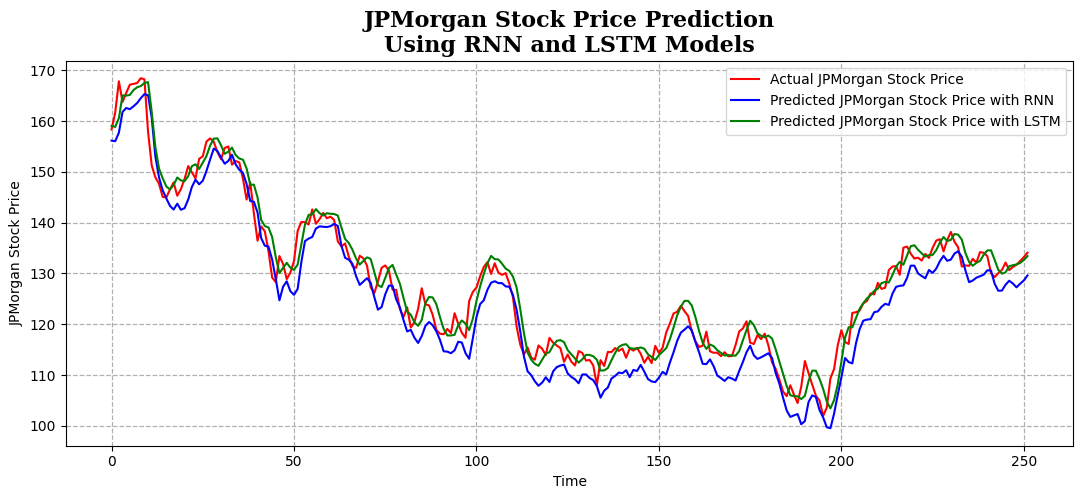

In [45]:
def plot_predictions(true_data, rnn_predictions, lstm_predictions):
    """
    Plots the true data along with predictions from RNN and LSTM models.

    Parameters:
    - true_data: Pandas Series or NumPy array containing the true data
    - rnn_predictions: Pandas Series or NumPy array containing the predictions
    from RNN model
    - lstm_predictions: Pandas Series or NumPy array containing the predictions
     from LSTM model

    Returns:
    - None
    """
    plt.figure(figsize=(13, 5))
    plt.plot(true_data, color='red', label='Actual JPMorgan Stock Price')
    plt.plot(rnn_predictions, color='blue',
             label='Predicted JPMorgan Stock Price with RNN')
    plt.plot(lstm_predictions, color='green',
             label='Predicted JPMorgan Stock Price with LSTM')

    # Title, labels, and legend
    plt.title('JPMorgan Stock Price Prediction\nUsing RNN and LSTM Models',
              fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel('JPMorgan Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()

    # Saving the plot
    plt.savefig('JPMorgan_stock_price_prediction_RNN_LSTM.png',
                dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

#  function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions
#with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions)

Finded that LSTM have less error comparing with other 2 models.so predicting the next 25 days of jp morgan stock using LSTM model.

**FORECASTING**

In [46]:
def pred_future_stock(model, base_data, days_to_predict,
                      scaler, look_back=2000):
  """
  Predict future stock values using the given LSTM 'model'.
  Parameters:
  - model: Trained LSTM model.
  - base_data: Time series data used as the starting point for prediction.
  - days_to_predict: Number of future days to predict.
  - scaler: Scaler used for data normalization.
  - look_back: Number of past days to consider for each prediction.
  Returns:
  - numpy.ndarray: Predicted future stock values.
  """
  # Start with the last days of the base data
  input_data = base_data[-look_back:].reshape(1, look_back, 1)

  # Predict future days
  future_predictions = []

  for _ in range(days_to_predict):

    # Make a prediction
    prediction = model.predict(input_data)

    # Append the prediction
    future_predictions.append(prediction[0, 0])

    # Update the input data to include the prediction and
    # exclude the oldest data point.
    # Correctly reshape the prediction to
    # (1, 1, 1) before appending
    input_data = np.append(input_data[:, 1:, :],
                           prediction.reshape(1, 1, 1), axis=1)

  # Invert the scaling
  reshaped = np.array(future_predictions).reshape(-1, 1)
  future_predictions = scaler.inverse_transform(reshaped)

  return future_predictions

In [47]:
# predicting the stock price by calling the function
days_to_pred = 25
future_days = pred_future_stock(lstm_model, scaled_data, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 [==============================] - 0s 47ms/step
(25, 1)


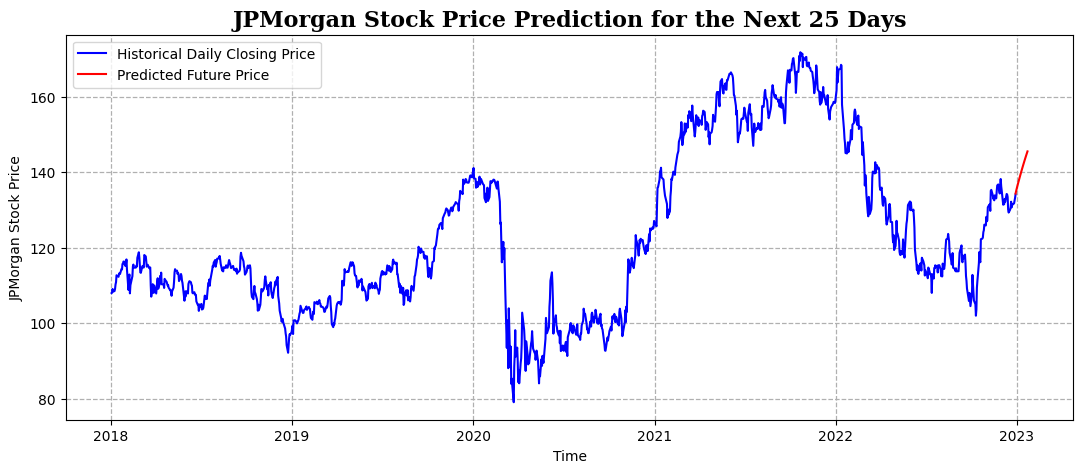

In [49]:
def plot_future_predictions(data, future_days):
    """
    Plots the predicted future prices along with historical data.

    Parameters:
    - data: Pandas DataFrame containing historical data with index as datetime
    - future_days: NumPy array containing predicted future prices

    Returns:
    - None
    """
    # Adjusting the dimensions of future_days array
    future_days = future_days.squeeze()

    # Plotting the predictions
    predicted_dates = pd.date_range(start=data.index[-1],
                                    periods=len(future_days))
    plt.figure(figsize=(13, 5))
    plt.plot(data.index, data['Close'], color='blue',
             label='Historical Daily Closing Price')
    plt.plot(predicted_dates, future_days, color='red',
             label='Predicted Future Price')
    plt.title(f'JPMorgan Stock Price Prediction for the Next {len(future_days)} Days',
          fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel('JPMorgan Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()
    plt.show()

# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data, future_days)

It is showing an upward trend for next 25 days,which is a good news for potential investors.